<a href="https://colab.research.google.com/github/thangyou123/Mathematical-Modeling-project/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import library

In [ ]:
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy import linalg as la
import time
import scipy
import pymc3
import datetime
from scipy.integrate import odeint
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense, LeakyReLU
from tensorflow.keras import optimizers
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


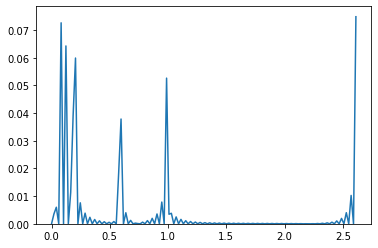

In [ ]:
sns.distplot(np.random.chisquare(df=0.001, size=1000), hist=False)

plt.show()


### Prepare data

,confirmed,removed
time,,
2020-01-21,282.0,0.0
2020-01-22,32.0,60.0
2020-01-23,267.0,60.0
2020-01-24,265.0,60.0
2020-01-25,474.0,60.0
2020-01-26,694.0,60.0


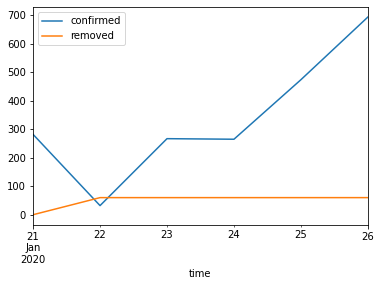

In [ ]:
data = {'time': ['1/21/20', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20'],
        'confirmed': [282, 314, 581, 846, 1320, 2014],
        'deaths': [0, 30, 60, 90, 120, 150],
        'recovered': [0, 30, 60, 90, 120, 150]}

df = pd.DataFrame(data, columns=['time', 'confirmed', 'deaths', 'recovered'])
df.time = pd.to_datetime(df.time)
df.set_index('time', inplace=True)
df['removed'] = df['deaths'] + df['recovered']
df.drop(['deaths', 'recovered'], axis=1, inplace=True)
df_next = df.shift(1).fillna(0)
covid_df = df - df_next
covid_df.plot()
covid_df

In [ ]:
country_list = ["Singapore", "Thailand", "Japan", "Australia", "Italy", "Indonesia", "Vietnam"]
N = 5_850_342 + 69_799_978 + 126_476_461 + 25_499_884 + 60_461_826 + 273_523_615 + 97_338_579

print("Countries: ", country_list)
print("Population: ", N)

def process_df(url, label, country_list):
  df = pd.read_csv(url)
  df.set_index("Country/Region", inplace=True)
  df.index.name = "Date"
  df = df.loc[country_list]
  df.drop(df.columns[:3], axis=1, inplace=True)
  df = df.T
  df[label] = df.sum(axis=1, skipna=True, numeric_only=True)
  df = df[[label]]
  return df

Countries:  ['Singapore', 'Thailand', 'Japan', 'Australia', 'Italy', 'Indonesia', 'Vietnam']
Population:  658950685


,recovered
7/2/20,284873.0


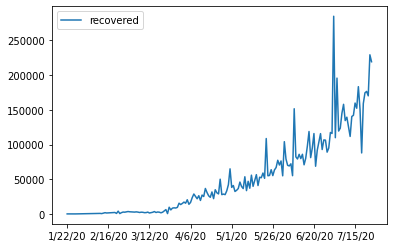

In [ ]:
date = datetime.datetime.today() - datetime.timedelta(days=1)

# url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_daily_reports/' + date.strftime("%m-%d-%Y") + '.csv'
url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered_df = pd.read_csv(url)
recovered_df.drop(recovered_df.columns[:4], axis=1, inplace=True)
recovered_df = recovered_df.T
recovered_df['recovered'] = recovered_df.sum(axis=1, skipna=True, numeric_only=True)
recovered_df = recovered_df[['recovered']]
df_next = recovered_df.shift(1).fillna(0)
recovered_df = recovered_df - df_next
recovered_df.plot()
recovered_df.tail()
recovered_df.loc[recovered_df.idxmax()]

Date,removed,infected
7/21/20,363091,62977
7/22/20,366149,63485
7/23/20,369030,64463
7/24/20,371878,65032
7/25/20,374035,66789


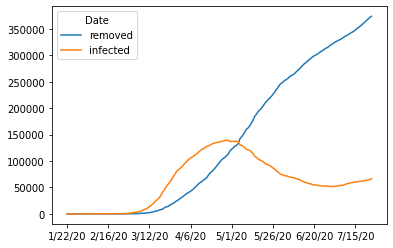

In [ ]:
recovered_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
death_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
confirmed_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

recovered_df = process_df(recovered_url, "removed", country_list)
death_df = process_df(death_url, "removed", country_list)
removed_df = recovered_df.add(death_df, fill_value=0)
confirmed_df = process_df(confirmed_url, "confirmed", country_list)
covid_df = removed_df.merge(confirmed_df, left_index=True, right_index=True)
covid_df['infected'] = covid_df['confirmed'] - covid_df['removed']
covid_df.drop(['confirmed'], axis=1, inplace=True)
covid_df.plot()
covid_df.tail()

In [ ]:
# N = 7_600_000_000
covid_df['suscepted'] = N - covid_df['removed'] - covid_df['infected']
# covid_df.plot()
covid_df.tail()

Date,removed,infected,suscepted
7/21/20,363091,62977,658524617
7/22/20,366149,63485,658521051
7/23/20,369030,64463,658517192
7/24/20,371878,65032,658513775
7/25/20,374035,66789,658509861


Date,removed,infected,suscepted
7/20/20,2628.0,799.0,3427.0
7/21/20,3058.0,508.0,3566.0
7/22/20,2881.0,978.0,3859.0
7/23/20,2848.0,569.0,3417.0
7/24/20,2157.0,1757.0,3914.0


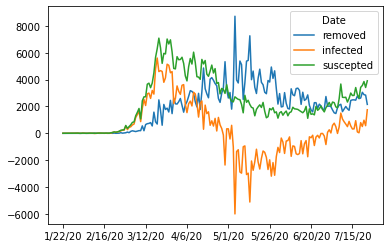

In [ ]:
covid_prev = covid_df.shift(-1)
covid_daily_df = covid_prev - covid_df
covid_daily_df['suscepted'] = -covid_daily_df['suscepted']
covid_daily_df.drop(covid_daily_df.index[-1], 0, inplace=True)
covid_daily_df.plot()
covid_daily_df.tail()

In [ ]:
size = covid_df.shape[0]
gammas = np.zeros(size)
betas = np.zeros(size)
for i in range(size-1):
  gammas[i] = (covid_df['removed'][i+1] - covid_df['removed'][i]) / covid_df['infected'][i]
  betas[i] = -(covid_df['suscepted'][i+1] - covid_df['suscepted'][i]) * N / (covid_df['infected'][i] * covid_df['suscepted'][i])
gammas[-1] = gammas[:-1].mean()
betas[-1] = betas[:-1].mean()
print("beta: ", betas[-1])
print("gamma: ", gammas[-1])
covid_df['beta'] = betas
covid_df['gamma'] = gammas
covid_df.tail()

beta:  0.09576430172905227
gamma:  0.03569968675347766


Date,removed,infected,suscepted,beta,gamma
7/21/20,363091,62977,658524617,0.056660,0.048557
7/22/20,366149,63485,658521051,0.060826,0.045381
7/23/20,369030,64463,658517192,0.053042,0.044180
7/24/20,371878,65032,658513775,0.060226,0.033168
7/25/20,374035,66789,658509861,0.095764,0.035700


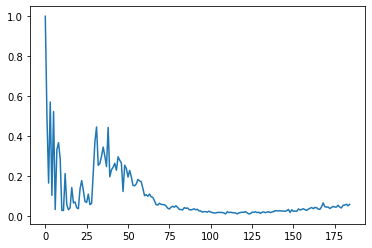

In [ ]:
plt.plot(range(betas.size-1), betas[:-1])

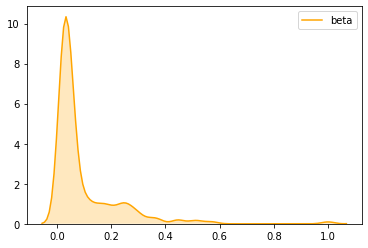

In [ ]:
sns.kdeplot(betas, shade=True, color='orange', label='beta')

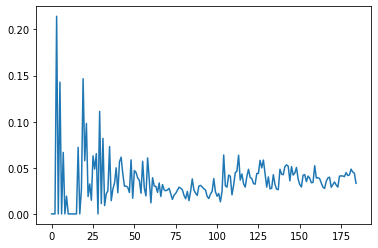

In [ ]:
plt.plot(range(gammas.size-1), gammas[:-1])

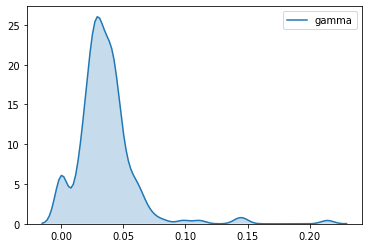

In [ ]:
sns.kdeplot(gammas, shade=True, label='gamma')

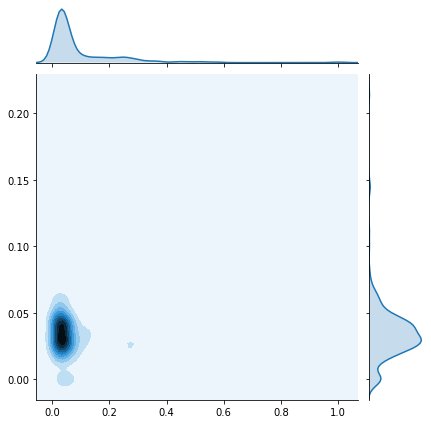

In [ ]:
sns.jointplot(betas, gammas, kind='kde')

In [ ]:
a = np.array(betas[:100]/gammas[:100])
a[a<np.inf].mean()

4.818957141692664

### Quest 2

In [ ]:
# SIR model with Euler method
def SIRModel(beta, gamma, N, S, I, R, iteration, start, end=None):
    times = pd.date_range(start, periods=iteration)

    for t in range (iteration-1):
        S[t+1] = S[t] - beta/N*S[t]*I[t]
        I[t+1] = I[t] + beta/N*S[t]*I[t] - gamma*I[t]
        R[t+1] = R[t] + gamma*I[t]

    # Read .csv file to get data
    # covid_df = pd.read_csv()
    
    data = {'suscepted': S,
            'infected': I,
            'removed': R}

    df = pd.DataFrame(data, columns=['suscepted', 'infected', 'removed'])
    df['Date'] = pd.to_datetime(times)
    df.set_index('Date', inplace=True)
    print(df.head(3))
    print(df.tail(8))

    plt.figure(figsize=(12, 10))

    # df.plot()
    df[['infected', 'removed']].plot()

    plt.title("SIR Model")
    plt.legend(fontsize=12)

0.0 4.0 658950681.0 0.09619195676452118 0.03566717694243853
               suscepted  infected   removed
Date                                        
2020-01-22  6.589507e+08  4.000000  0.000000
2020-01-23  6.589507e+08  4.242099  0.142669
2020-01-24  6.589507e+08  4.498851  0.293972
               suscepted       infected       removed
Date                                                 
2020-07-12  6.587948e+08   98058.940060  57794.197341
2020-07-13  6.587854e+08  103991.704873  61291.682907
2020-07-14  6.587754e+08  110283.270838  65000.773445
2020-07-15  6.587648e+08  116955.319648  68934.266380
2020-07-16  6.587535e+08  124030.840955  73105.732460
2020-07-17  6.587416e+08  131534.210998  77529.562411
2020-07-18  6.587290e+08  139491.275917  82221.016388
2020-07-19  6.587156e+08  147929.440044  87196.276409


<Figure size 864x720 with 0 Axes>

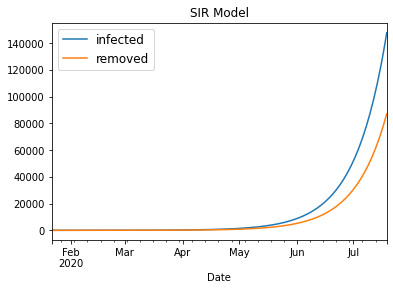

In [ ]:
iteration = 180
start = '22-01-2020'

S = np.zeros(iteration)
I = np.zeros(iteration)
R = np.zeros(iteration)

R[0], I[0], S[0], beta, gamma = covid_df.iloc[0]

beta = betas[-1]
gamma = gammas[-1]
print(R[0], I[0], S[0], beta, gamma)

SIRModel(beta, gamma, N, S, I, R, iteration, start)

In [ ]:
# Continuous SIR model

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

<Figure size 864x720 with 0 Axes>

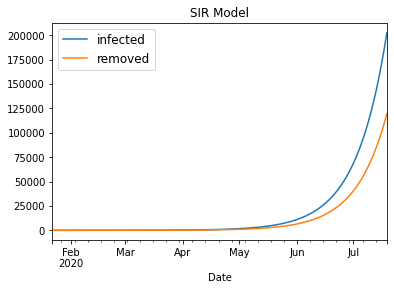

In [ ]:
t = np.linspace(0, iteration-1, iteration) # Grid of time points (in days)
y0 = S[0], I[0], R[0] # Initial conditions vector
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

data = {'suscepted': S,
            'infected': I,
            'removed': R}

times = pd.date_range(start, periods=iteration)
df = pd.DataFrame(data, columns=['suscepted', 'infected', 'removed'])
df['Date'] = pd.to_datetime(times)
df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 10))

# df.plot()
df[['infected', 'removed']].plot()

plt.title("SIR Model")
plt.legend(fontsize=12)

### Quest 3

In [ ]:
def prior(w):
    if(w[0]<=0 or w[1] <=0):
        return 0
    else:
        return 1
    
def manual_log_lik_gamma(x,data):
    return np.sum((x[0]-1)*np.log(data) - (1/x[1])*data - x[0]*np.log(x[1]) - np.log(math.gamma(x[0])))  

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept <= (np.exp(x_new-x)))

def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x, data)
        x_new_lik = likelihood_computer(x_new, data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

In [ ]:
def clean_data(data):
  size = 0

  data = data[data > 0]

  while size != data.size:
    mean = data.mean()
    std = data.std()
    size = data.size

    data = data[data < mean + 3*std]
    data = data[data > mean - 3*std]
    break

  return data

(61422, 2) (38578, 2)


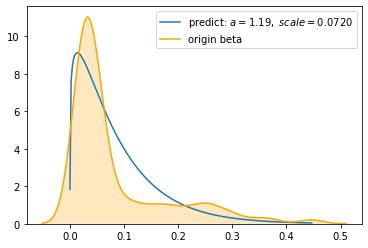

In [ ]:
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: np.random.normal(x, [0.05, 0.005] ,(2,))
beta_data = np.array(covid_df['beta'])[:-1]
# beta_data = beta_data[beta_data > 0]
beta_data = clean_data(beta_data)

accepted, rejected = metropolis_hastings(manual_log_lik_gamma, prior, transition_model, [1.7, 0.035], 100000, beta_data, acceptance)
print(accepted.shape, rejected.shape)
burn_in = int(accepted.shape[0] * 0.2)
beta_a, beta_scale = accepted[burn_in:].mean(axis=0)

t = np.linspace(1E-6, beta_data.max(), 200)
beta_dist = scipy.stats.gamma(beta_a, 0, beta_scale)

plt.plot(t, beta_dist.pdf(t), label=r'predict: $a=%.2f,\ scale=%.4f$' % (beta_a, beta_scale))
sns.kdeplot(beta_data, shade=True, color='orange', label='origin beta')
plt.legend()

(4176, 2) (95824, 2)


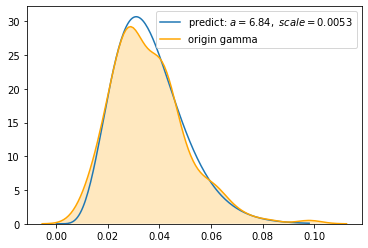

In [ ]:
transition_model = lambda x: np.random.normal(x, [0.05, 0.005] ,(2,))
gamma_data = np.array(covid_df['gamma'])[:-1]
gamma_data = clean_data(gamma_data)

accepted, rejected = metropolis_hastings(manual_log_lik_gamma, prior, transition_model, [2, 0.01], 100000, gamma_data, acceptance)
print(accepted.shape, rejected.shape)
burn_in = int(accepted.shape[0] * 0.2)
gamma_a, gamma_scale = accepted[burn_in:].mean(axis=0)

t = np.linspace(1E-6, gamma_data.max(), 200)
gamma_dist = scipy.stats.gamma(gamma_a, 0, gamma_scale)

plt.plot(t, gamma_dist.pdf(t), label=r'predict: $a=%.2f,\ scale=%.4f$' % (gamma_a, gamma_scale))
sns.kdeplot(gamma_data, shade=True, color='orange', label='origin gamma')
plt.legend()

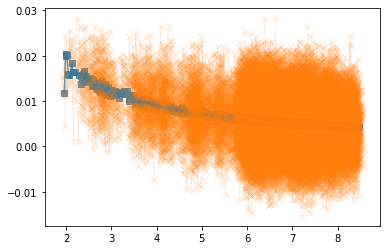

In [ ]:
start_point = 0

plt.plot(accepted[start_point:, 0], accepted[start_point:, 1], alpha=0.8, marker='s')
plt.plot(rejected[start_point:, 0], rejected[start_point:, 1], alpha=0.2, lw=0.5, marker='x')

In [ ]:
scipy.stats.norm(loc=0, scale=1).pdf(2.58)

0.014305108994149692

In [ ]:
def norm_pdf(x):
  return scipy.stats.norm(loc=0, scale=1).pdf(x)

def gamma_pdf(x):
  if x < 0:
    return 0
  else:
    return scipy.stats.gamma(a=gamma_a, scale=gamma_scale).pdf(x)

def multi_gamma(x):
  if x[0] <= 0 or x[1] <= 0:
    return 0
  return beta_dist.pdf(x[0]) * gamma_dist.pdf(x[1])

def norm_gamma(x):
  if x[0] <= 0 or x[1] <= 0:
    return 0
  return scipy.stats.norm(loc=0.07, scale=0.05).pdf(x[0]) * gamma_dist.pdf(x[1])

def norm_norm(x):
  if x[0] <= 0 or x[1] <= 0:
    return 0
  return scipy.stats.norm(loc=2, scale=1).pdf(x[0]) * scipy.stats.norm(loc=2, scale=1).pdf(x[1])

def metropolis_hasting(prior, iteration, param_init, transition_model):
  shape = param_init.size
  sample = np.zeros((iteration, shape))
  sample[0] = param_init
  reject = 0

  for i in range (1, iteration):
    current = sample[i-1]
    propose = transition_model(current)
    a = prior(propose) / prior(current)
    rand = np.random.rand()

    if a < rand:
      sample[i] = current
      reject += 1
    else:
      sample[i] = propose

  print(reject)
  return sample


2932


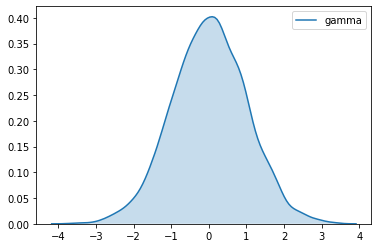

In [ ]:
transition_model = lambda x: np.random.normal(x, 1, 1)
iter = 10000
param_init = np.array([0.07])

sample = metropolis_hasting(norm_pdf, iter, param_init, transition_model)
# sample[:5]
sns.kdeplot(sample[:, 0], shade=True, label='gamma')

In [ ]:
np.random.normal([0, 1], [1, 1], 2)

array([ 1.43754984, -0.11458883])

1545


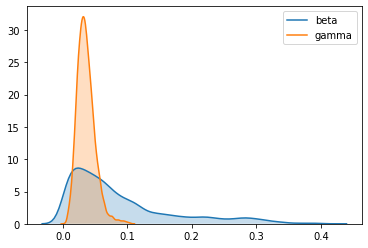

In [ ]:
transition_model = lambda x: np.random.normal(x, [0.01, 0.005], 2)
iter = 10000
param_init = np.array([0.07, 0.025])

sample = metropolis_hasting(multi_gamma, iter, param_init, transition_model)
# sample[:5]
sns.kdeplot(sample[:, 0], shade=True, label='beta')
sns.kdeplot(sample[:, 1], shade=True, label='gamma')

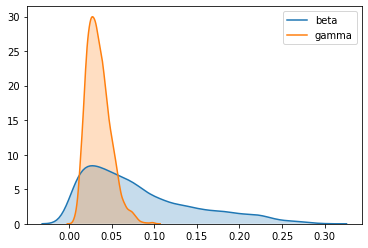

In [ ]:
sns.kdeplot(sample[:, 0], shade=True, label='beta')
sns.kdeplot(sample[:, 1], shade=True, label='gamma')
# plt.savefig('multi_gamma.png')

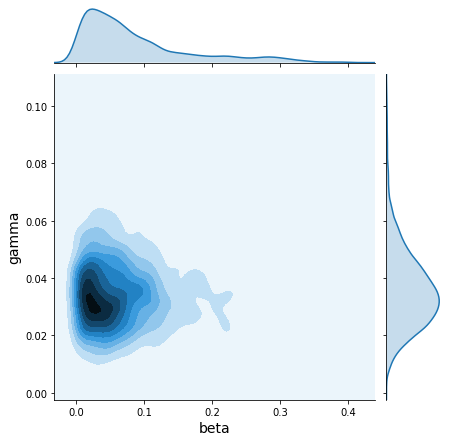

In [ ]:
ax = sns.jointplot(sample[:, 0], sample[:, 1], kind='kde')
ax.set_axis_labels("beta", "gamma", fontsize=14)

### Quest 4

In [ ]:
def log_poisson(mu, x):
    return scipy.stats.poisson(mu).logpmf(x)

def log_normal(mu, sigma, x):
    return scipy.stats.norm.logpdf(x, loc=mu, scale=sigma)

def beta_logpdf(x):
    return beta_dist.logpdf(x)

def gamma_logpdf(x):
    return gamma_dist.logpdf(x)

def log_prior(x):
    if x[0] <= 0 or x[1] <=0:
        return -np.inf
    return beta_logpdf(x[0]) + gamma_logpdf(x[1])

def log_likelihood(x, data):
    if x[0] <= 0 or x[1] <=0:
        return -np.inf
    size = data.shape[0]
    S = np.zeros(size)
    I = np.zeros(size)
    R = np.zeros(size)

    I[0], R[0] = data[0]
    S[0] = N - I[0] - R[0]

    for i in range(size-1):
      I[i+1] = data[i, 0] + x[0]*data[i, 0]*S[i]/N - x[1]*data[i, 0]
      R[i+1] = data[i, 1] + x[1]*data[i, 0]
      S[i+1] = N - data[i+1, 0] - data[i+1, 1]

    # res = -np.sum(np.log(np.square(data[:, 0] - I)+1)) - np.sum(np.log(np.square(data[:, 1] - R)+1))
    res = -np.sum(np.log(np.square((data[:, 0] - I)/(data[:, 0]+1))+1)) - np.sum(np.log(np.square((data[:, 1] - R)/(data[:, 1]+1))+1))

    return res

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0,1)
        return accept <= (np.exp(x_new-x))

def metropolis_hastings(likelihood_computer, prior, transition_model, param_init, iterations, data, acceptance_rule, burn_in=0):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of iterations to generated
    # data: the data that we wish to model
    # acceptance_rule(x, x_new): decides whether to accept or reject the new sample
    
    x = param_init
    accepted = []
    rejected = []
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x, data) + prior(x)
        x_new_lik = likelihood_computer(x_new, data) + prior(x_new)
        if (acceptance_rule(x_lik, x_new_lik)):            
            x = x_new
            accepted.append(x_new)
        else:
            accepted.append(x)
            rejected.append(x_new)
                
    return np.array(accepted[burn_in:]), np.array(rejected)

In [ ]:
beta_dist = scipy.stats.gamma(a=1, scale=0.5)
gamma_dist = scipy.stats.gamma(a=1, scale=0.3)
# beta_dist = scipy.stats.norm(loc=0, scale=0.1)
# gamma_dist = scipy.stats.norm(loc=0, scale=0.05)
data = np.array(covid_df[['infected', 'removed']])
val = [0.0005, 0.0312]
log_likelihood(val, data) + log_prior(val)

-1.9406324418849934

In [ ]:
# Sample from estimated distributions
transition_model = lambda x: np.random.normal(x, [0.01, 0.005], 2)
iter = 10000
burn_in = int(0.2*iter)
param_init = np.array([0.07, 0.025])

accepted, rejected = metropolis_hastings(log_likelihood, log_prior, transition_model, param_init, iter, data, acceptance, burn_in)

In [ ]:
print(rejected.shape)
accepted[-5:]

(1453, 2)


array([[0.05471007, 0.03097168],
       [0.05952561, 0.03364881],
       [0.05074743, 0.03798035],
       [0.04657729, 0.0432258 ],
       [0.04657729, 0.0432258 ]])

In [ ]:
print(accepted[:, 0].sum() / accepted[:, 1].sum())
(accepted[:, 0] / accepted[:, 1]).mean()

2.6309063599256297


6.428384030550855

In [ ]:
quantiles = np.quantile(accepted, [0.025, 0.975], axis=0).T
pd.DataFrame(quantiles, index=['\u03B2', '\u03B3'], columns=['2.5%', '97.5%'])

,2.5%,97.5%
β,0.004557,0.179683
γ,0.002469,0.061525


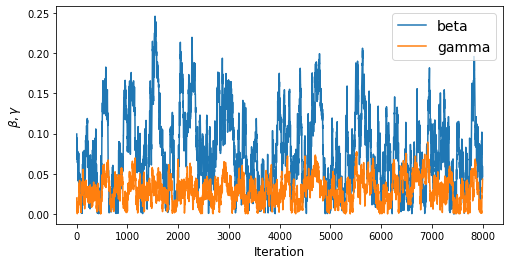

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(accepted.shape[0]), accepted[:, 0], label='beta')
plt.plot(range(accepted.shape[0]), accepted[:, 1], label='gamma')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel(r'$\beta, \gamma$', fontsize=12)
plt.legend(fontsize=14)

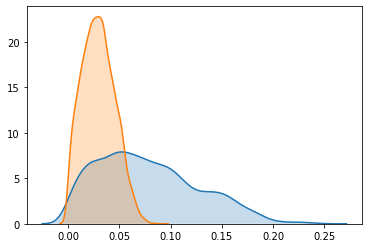

In [ ]:
sns.kdeplot(accepted[:, 0], shade=True)
sns.kdeplot(accepted[:, 1], shade=True)

Text(0.5, 49.99999999999995, 'sfdf')

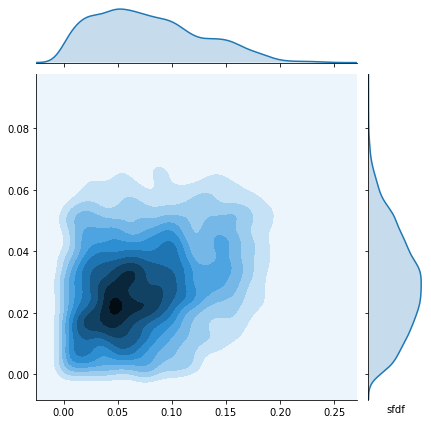

In [ ]:
sns.jointplot(accepted[:, 0], accepted[:, 1], kind='kde')

In [ ]:
size = sample.shape[0]
mean_rate = 0

data = betas[:-1]
# data = MinMaxScaler(feature_range=(1E-6, 0.5)).fit_transform(data)
print(data[-5:])
for i in range(size):
  mean_rate += math.exp(manual_log_lik_gamma(sample[i], data)) * sample[i, 0]/sample[i, 1]

print(mean_rate)

NameError: ignored

In [ ]:
data = np.array(covid_df[['infected']])
# data = MinMaxScaler(feature_range=(1E-10, 0.1)).fit_transform(data)
print(data[-5:])
print(sample[0])
math.exp(manual_log_lik_gamma(sample[0], data))
math.gamma(700)

In [ ]:
data = np.array(covid_df['infected'])

i = 0
b = sample[i, 0]
g = sample[i, 1]
x = 1
for j in range(data.size):
  x *= pow(g, b) * pow(data[j], b-1) * math.exp(-g*data[j]) / math.gamma(b)
print(x)

nan


In [ ]:
saved_sample = sample

In [ ]:
sample = saved_sample[2000:] * 10

In [ ]:
sample[:5]

array([[0.69574824, 0.31316127],
       [0.65092663, 0.28648446],
       [0.58182808, 0.20659869],
       [0.65209371, 0.35162554],
       [0.55998621, 0.44965817]])

In [ ]:
size = sample.shape[0]
mean_rate = 0

data = np.array(covid_df[['infected']])
data = MinMaxScaler((0, 1)).fit_transform(data)
for i in range(size):
  func = (sample[i, 0]) * data
  mean_rate += np.prod(np.exp(-func)) * sample[i, 0] / sample[i, 1]

print(mean_rate/data.shape[0])

2.3295783090958473


In [ ]:
size = sample.shape[0]
mean_rate = 0

data = np.array(covid_df[['infected']])[:100]
# data = MinMaxScaler((0, 1)).fit_transform(data)
for i in range(size):
  func = (sample[i, 0]/N) * data
  mean_rate += np.prod(np.exp(-func)) * sample[i, 0]/sample[i, 1]

print(mean_rate/size)

2.7458541042468467


### Quest 5

In [ ]:
# Helper function

def SIR_fp(beta, gamma, S0, I0, R0, iteration):
    N = S0 + I0 + R0
    S = np.zeros(iteration)
    I = np.zeros(iteration)
    R = np.zeros(iteration)

    S[0], R[0], I[0] = S0, R0, I0

    for t in range (iteration-1):
        S[t+1] = S[t] - beta[t]/N*S[t]*I[t]
        I[t+1] = I[t] + beta[t]/N*S[t]*I[t] - gamma[t]*I[t]
        R[t+1] = R[t] + gamma[t]*I[t]

    return np.array([I, R])

def custom_loss(y_true, y_pred):
  loss = K.square(y_true-y_pred)
  loss = K.sum(loss, axis=1)
  return loss

def look_back(step, data):
  sizeX = data.shape[0]
  sizeY = data.shape[1]

  new_data = []

  for i in range(sizeX-step):
    new_data.append(data[i: i+step])

  print(np.array(new_data).shape)
  res_data = np.array(new_data).reshape(sizeX-step, sizeY*step)

  return res_data

def load_data():
  train_test_split = covid_df.shape[0] - 1 
  train_data = np.array(covid_df[['infected', 'removed']][:train_test_split])
  train_data = train_data[5:]

  step = 7

  train_data = look_back(step, train_data)

  return train_data

def plot_model(model, train_data, min_loss):
  N0 = N
  size = train_data.shape[0]

  predict = model.predict(train_data) / 100
  I0, R0 = train_data[0][:2]
  result = SIR_fp(predict[:, 0], predict[:, 1], N0 - I0 - R0, I0, R0, size).T
  plt.plot(range(size), result[:, 0])
  plt.plot(range(size), result[:, 1])
  plt.plot(range(size), train_data[:, 0], alpha=0.5)
  plt.plot(range(size), train_data[:, 1], alpha=0.5)
  plt.show()
  print(predict[0:10])
  print(predict[-10:])
  print(min_loss)

In [ ]:
# Load data
train_test_split = covid_df.shape[0] - 1 
train_data = np.array(covid_df[['infected', 'removed']][:train_test_split])
train_data = train_data[5:]

step = 7

train_data = look_back(step, train_data)

(169, 7, 2)


In [ ]:
model = Sequential([
            BatchNormalization(input_shape=(2*step,)),
            Dense(8, activation='relu'),
            Dense(2, activation='relu')
])

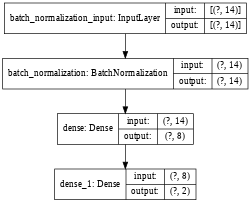

In [ ]:
# Show model structure
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48, to_file="model_neuron.png")

In [ ]:
# Define loss function and optimizer
loss_object = tf.keras.losses.MeanSquaredError(reduction='sum')
loss_object_log = tf.keras.losses.MeanSquaredLogarithmicError(reduction='sum')

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
def loss(model, x, y, training=True):
  N0 = N
  y_pred = model(x, training=training)
  y_pred /= 100
  x = x.astype('float32')

  I0, R0 = x[0][:2]
  S0 = N0 - I0 - R0
  iteration = x.shape[0]
  S = [S0]
  I = [I0]
  R = [R0]

  for t in range (iteration-1):
      S.append(S[t] - y_pred[t, 0]/N0*S[t]*I[t])
      I.append(I[t] + y_pred[t, 0]/N0*S[t]*I[t] - y_pred[t, 1]*I[t])
      R.append(R[t] + y_pred[t, 1]*I[t])

  IR_pred = tf.stack([I, R], 1)

  max_I = np.array(I).max()
  max_init = y.max()

  E_d1 = loss_object_log(x[:, :2], IR_pred)
  E_d2 = 0.01 * np.log10(max_I)/max_I*loss_object(x[:, :2], IR_pred)
  E_r = 100 * np.log10(max_I)/max_init*loss_object(y, y_pred[0])
  E_0 = 100 * np.log10(max_I)/max_init*loss_object(y_pred[:-1], y_pred[1:])
  return E_d1 + E_d2 + E_r + E_0

def grads(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# Load data
train_data = load_data()

# Train model
train_loss_results = []

num_epochs = 15001
# Initialize for beta0, gamma0
init_value = np.array([0.196, 0.037])
train_label = init_value

min_loss = np.inf
min_epochs = []
early_stop_cnt = 0

for epoch in range(num_epochs):
  if epoch == 2000:
    optimizer.learning_rate.assign(0.005)
  elif epoch == 6000:
    optimizer.learning_rate.assign(0.002)
  elif epoch == 11000:
    optimizer.learning_rate.assign(0.001)

  # Use for batch training
  epoch_loss_avg = tf.keras.metrics.Mean()

  loss_value, gradient = grads(model, train_data, train_label)
  optimizer.apply_gradients(zip(gradient, model.trainable_variables))

  epoch_loss_avg.update_state(loss_value)
  train_loss_results.append(epoch_loss_avg.result())

  # Store min loss of model
  if epoch_loss_avg.result().numpy() < min_loss:
    min_loss = epoch_loss_avg.result().numpy()
    min_epochs.append(epoch)
    early_stop_cnt = 0
  else:
    early_stop_cnt += 1

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    
print(min_loss)

In [ ]:
# For more training ...
num_epochs = 1001

for epoch in range(num_epochs):

  # Use for batch training
  epoch_loss_avg = tf.keras.metrics.Mean()

  loss_value, gradient = grads(model, train_data, train_label)
  optimizer.apply_gradients(zip(gradient, model.trainable_variables))

  epoch_loss_avg.update_state(loss_value)
  train_loss_results.append(epoch_loss_avg.result())

  # Store min loss of model
  if epoch_loss_avg.result().numpy() < min_loss:
    min_loss = epoch_loss_avg.result().numpy()
    min_epochs.append(epoch)
    early_stop_cnt = 0
  else:
    early_stop_cnt += 1

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

Epoch 000: Loss: 153.128
Epoch 050: Loss: 152.988
Epoch 100: Loss: 152.859
Epoch 150: Loss: 152.729
Epoch 200: Loss: 152.595
Epoch 250: Loss: 152.460
Epoch 300: Loss: 152.321
Epoch 350: Loss: 152.181
Epoch 400: Loss: 152.038
Epoch 450: Loss: 151.893
Epoch 500: Loss: 151.747
Epoch 550: Loss: 151.598
Epoch 600: Loss: 151.447
Epoch 650: Loss: 151.293
Epoch 700: Loss: 151.137
Epoch 750: Loss: 150.978
Epoch 800: Loss: 150.824
Epoch 850: Loss: 150.667
Epoch 900: Loss: 150.507
Epoch 950: Loss: 150.341
Epoch 1000: Loss: 150.175


Text(0.5, 1.0, 'Training loss')

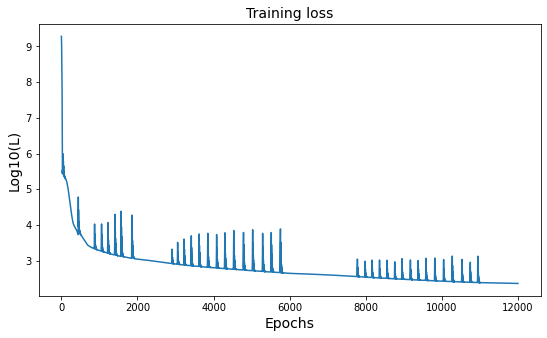

In [ ]:
# Plot first 12000 training steps
if len(train_loss_results) > 12000:
  result = train_loss_results[:12000]
else:
  result = train_loss_results
plt.figure(figsize=(9, 5))

plt.plot(range(len(result)), np.log10(result))
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Log10(L)", fontsize=14)
plt.title("Training loss", fontsize=14)

# plt.savefig("saved_model/train_loss.png")

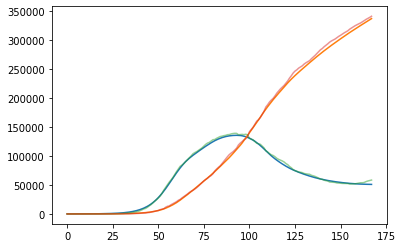

[[0.1907523  0.03140557]
 [0.19074318 0.03140395]
 [0.1907386  0.03140766]
 [0.19073567 0.03141136]
 [0.19072868 0.03141048]
 [0.19072457 0.03141363]
 [0.19072042 0.03141527]
 [0.19071679 0.03141698]
 [0.19071178 0.03141861]
 [0.19070399 0.03141828]]
[[0.0354571  0.03927409]
 [0.03555796 0.03911543]
 [0.03565477 0.03855509]
 [0.03581535 0.03824374]
 [0.03607873 0.03811875]
 [0.0364664  0.03824452]
 [0.03693027 0.03860972]
 [0.03740696 0.0387507 ]
 [0.03789228 0.03899641]
 [0.03844647 0.03920313]]
153.12141


In [ ]:
plot_model(model, train_data, min_loss)

In [ ]:
# Save trained model
!mkdir -p saved_model

path = 'saved_model/model.h5'
model.save(path, save_format='tf')
unreplicated_model = tf.keras.models.load_model(path)

In [ ]:
# For fast checkout, load pretrained model
unreplicated_model = tf.keras.models.load_model("saved_model/model.h5")

In [ ]:
N0 = N
size = train_data.shape[0]

predict = unreplicated_model.predict(train_data) / 100
I0, R0 = train_data[0][:2]
result = SIR_fp(predict[:, 0], predict[:, 1], N0 - I0 - R0, I0, R0, size).T

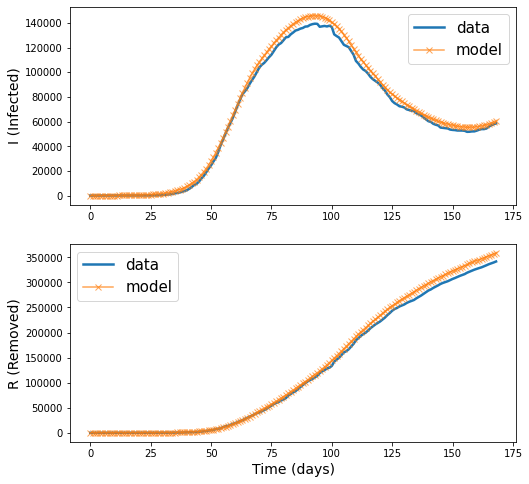

In [ ]:
# Plot infected and removed cases
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(range(size), train_data[:, 0], lw=2.5, label="data")
plt.plot(range(size), result[:, 0], alpha=0.7, marker='x', label="model")
plt.ylabel("I (Infected)", fontsize=14)
plt.legend(fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(range(size), train_data[:, 1], lw=2.5, label="data")
plt.plot(range(size), result[:, 1], alpha=0.7, marker='x', label="model")
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("R (Removed)", fontsize=14)
plt.legend(fontsize=15)

In [ ]:
result_daily = result[1:] - result[:-1]
train_daily = train_data[1:] - train_data[:-1]

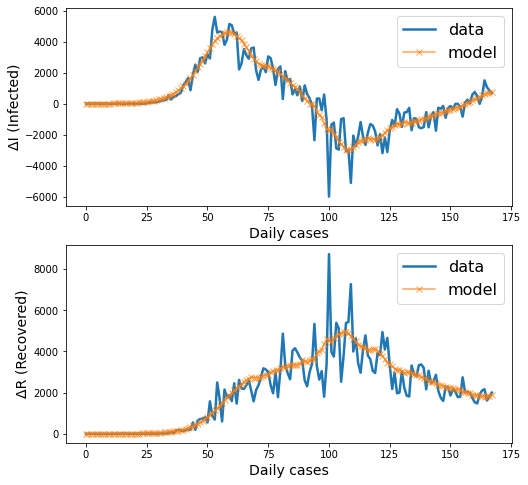

In [ ]:
# Plot daily infected and removed cases
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(range(size-1), train_daily[:, 0], lw=2.5, label="data")
plt.plot(range(size-1), result_daily[:, 0], alpha=0.7, marker='x', label="model")
plt.xlabel("Daily cases", fontsize=14)
plt.ylabel("\u0394I (Infected)", fontsize=14)
plt.legend(fontsize=16)

plt.subplot(2, 1, 2)
plt.plot(range(size-1), train_daily[:, 1], lw=2.5, label="data")
plt.plot(range(size-1), result_daily[:, 1], alpha=0.7, marker='x', label="model")
plt.xlabel("Daily cases", fontsize=14)
plt.ylabel("\u0394R (Recovered)", fontsize=14)
plt.legend(fontsize=16)

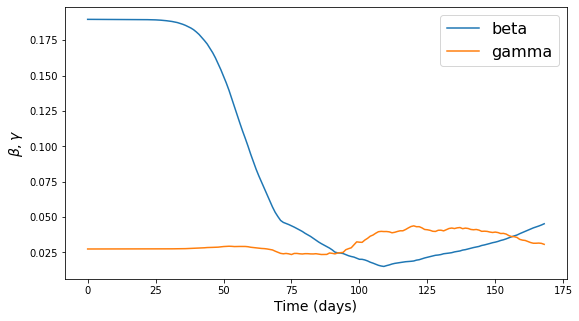

In [ ]:
# Plot for predicted beta, gamma
plt.figure(figsize=(8, 4))
plt.plot(range(size), predict[:, 0], lw=1.5, label="beta")
plt.plot(range(size), predict[:, 1], lw=1.5, label="gamma")
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel(r"$\beta , \gamma$", fontsize=14)
plt.legend(fontsize=16)
# plt.savefig("saved_model/beta_gamma")

Text(0, 0.5, '$R_0$')

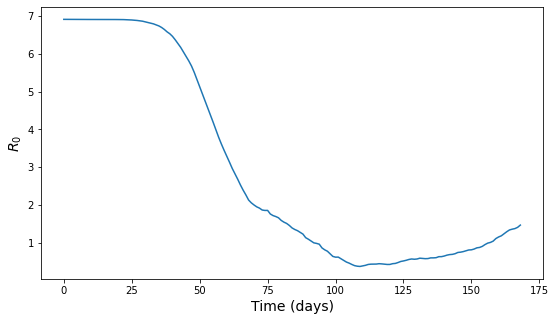

In [ ]:
# Plot for predicted R0
plt.figure(figsize=(8, 4))
plt.plot(range(size), predict[:, 0] / predict[:, 1], lw=1.5)
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel(r"$R_0$", fontsize=14)
# plt.savefig("saved_model/R0.png")

In [ ]:
np.array(predict[:, 0] / predict[:, 1])[:100].mean()

4.4380183

In [ ]:
!zip -r model2.zip saved_model

from google.colab import files
files.download("model2.zip")

updating: saved_model/ (stored 0%)
updating: saved_model/I_predict.png (deflated 5%)
updating: saved_model/beta_gamma.png (deflated 7%)
updating: saved_model/R_daily_predict.png (deflated 3%)
updating: saved_model/R0.png (deflated 8%)
  adding: saved_model/.ipynb_checkpoints/ (stored 0%)
  adding: saved_model/model.h5 (deflated 87%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>